In [1]:
import numpy as np
import pandas as pd

In [2]:
import operator

from copy import copy

In [3]:
from sklearn.metrics import mean_squared_error

In [4]:
import matplotlib.pyplot as plt

%matplotlib inline

In [5]:
df = pd.read_csv("../data/train.txt", sep='\t', header=None, names=["users", "items", "rank"])
df.head()

,users,items,rank
0,1,1,5
1,1,2,3
2,1,3,4
3,1,4,3
4,1,5,3


In [6]:
df["rank"].unique()

array([5, 3, 4, 1, 2])

In [7]:
n_users = df["users"].max()
n_items = df["items"].max()

In [8]:
df[["users", "items"]] -= 1
df.head()

,users,items,rank
0,0,0,5
1,0,1,3
2,0,2,4
3,0,3,3
4,0,4,3


In [9]:
def score(matrix, values):
    y_pred = [matrix[user, item] for user, item, rank in values]
    y_true = map(operator.itemgetter(2), values)
    return mean_squared_error(y_true, y_pred)

In [10]:
def iter_step(weights, df_grouped, C):
    weights_ = copy(weights)
    
    for user, group in df_grouped["users"]:
        Q = weights_["items"][group["items"].values]
        r = group["rank"].values
        
        A = np.dot(Q.T, Q) + C * np.eye(Q.shape[1])
        b = np.dot(Q.T, r)
        
        weights_["users"][user] = np.linalg.solve(A, b)
    
    for item, group in df_grouped["items"]:
        P = weights_["users"][group["users"].values]
        r = group["rank"].values
        
        A = np.dot(P.T, P) + C * np.eye(P.shape[1])
        b = np.dot(P.T, r)
        
        weights_["items"][item] = np.linalg.solve(A, b)
    
    return weights_

In [11]:
C = 5
n_features = 4

In [12]:
b = []

for j in range(20):
    index = np.random.permutation(df.shape[0])
    alpha = int(0.8 * len(index))

    df_train, df_valid = df.iloc[index[:alpha]], df.iloc[index[alpha:]]
    
    df_grouped = {cat : df_train.groupby(by=cat) for cat in ["users", "items"]}
    
    weights = dict()
    weights["users"] = np.random.normal(loc=0.0, scale=0.01, size=(n_users, n_features))
    weights["items"] = np.random.normal(loc=0.0, scale=0.01, size=(n_items, n_features))
    
    scores = []
    
    n_iters = 50

    for i in range(n_iters):
        weigths = iter_step(weights, df_grouped, C)
            
        matrix = np.dot(weights["users"], weights["items"].T)
        scores.append(
            (score(matrix, df_train.values),
             score(matrix, df_valid.values))
        )
        
        print "\r{}: {} of {} iters passed...".format(j, i + 1, n_iters),
        
    a = map(operator.itemgetter(1), scores)
    print "\r{:>02} {:>7.5f} {:>7.5f}".format(np.argmin(a) + 1, np.min(a), a[-1])
    
    b.append(np.argmin(a) + 1)
np.mean(b)

36 0.87844 0.87864
32 0.90193 0.90301
35 0.91718 0.91805
42 0.89026 0.89028
50 0.87437 0.87437
50 0.86730 0.86730
50 0.90146 0.90146
50 0.89641 0.89641
50 0.90973 0.90973
50 0.91736 0.91736
22 0.88686 0.89014
50 0.88641 0.88641
40 0.89503 0.89506
22 0.90237 0.90829
37 0.88329 0.88376
32 0.88135 0.88189
50 0.89333 0.89333
30 0.91151 0.91301
50 0.91375 0.91375
32 0.89821 0.89872


40.5

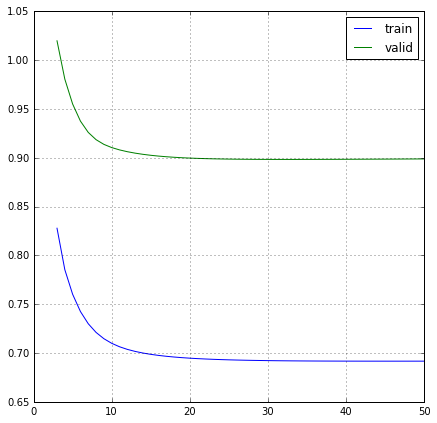

In [13]:
offset = 2

plt.figure(figsize=(7, 7))
plt.plot(range(offset+1, len(scores)+1), map(operator.itemgetter(0), scores)[offset:], label="train")
plt.plot(range(offset+1, len(scores)+1), map(operator.itemgetter(1), scores)[offset:], label="valid")
plt.legend()
plt.grid()

In [14]:
# np.argsort(map(operator.itemgetter(1), scores))

In [15]:
# np.min(map(operator.itemgetter(1), scores))